In [1]:
import numpy as np
import matplotlib.pylab as plt
import astropy.units as u
from astropy.constants import c
%matplotlib inline

In [2]:
def resolution(Dratio, freq, tau):
    """
    Dratio: Ds/Di, the ratio of the distance to the interstellar screen and to the source
    freq: Observing frequency, astropy unit
    tau: Scattering timescale of observation, astropy unit
    """
    theta = theta_scaling(freq)
    lam = (c/freq).decompose()    
    Dls = ( (lam/theta) * (Dratio-1) )**2.0 / (2*c*tau)
    return Dls.to(u.pc)

def theta_scaling(freq):
    t_mas = 14.* (freq / (325*u.MHz))**(-1.66) # From Rudnitskii 2016
    theta = t_mas.value / (206264.806247 * 1000) # Converison to radians
    return theta

def tel_resolution(freq, b):
    lam = (c / freq).decompose()
    b = b*u.km
    res = (lam / b).decompose()
    res_mas = res * (206264.806247 * 1000)
    return res_mas

In [3]:
freq = 800*u.MHz
tau = 50*u.microsecond

Dratio = 2.

res = resolution(Dratio, freq, tau)

print res

6.55677645329e-07 pc


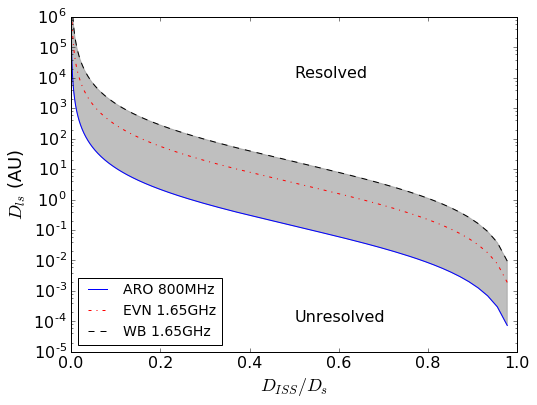

In [4]:
""" ARO 800MHz constraints """

Dratio = np.logspace(0.01, 10, 1000)

tauARO = 50*u.microsecond
freqARO = 800*u.MHz
DlsARO = resolution(Dratio, freqARO, tauARO)

""" EVN 1.6GHz constraints """

tauEVN = 5*u.microsecond
freqEVN = 1650*u.MHz
DlsEVN = resolution(Dratio, freqEVN, tauEVN)

""" Wb 1.6GHz constaints """

tauWB = 1.*u.microsecond
freqWB = 1650*u.MHz
DlsWB = resolution(Dratio, freqWB, tauWB)

""" Plotting """

plt.figure(figsize=(8,6))

plt.plot( 1/Dratio, DlsARO.to(u.au), 'b', label='ARO 800MHz')
plt.plot( 1/Dratio, DlsEVN.to(u.au), 'r-.', label='EVN 1.65GHz')
plt.plot( 1/Dratio, DlsWB.to(u.au), 'k--', label='WB 1.65GHz')

plt.fill_between(1/Dratio, DlsARO.to(u.au).value, DlsWB.to(u.au).value, color='grey', alpha=0.5)

#plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-5, 1e6)

plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)

plt.ylabel(r'$D_{ls}$ (AU)', fontsize=18)
plt.xlabel(r'$D_{ISS} / D_{s}$', fontsize=18)

plt.legend(fontsize=14, loc=3)

plt.text(0.5,10000, 'Resolved', fontsize = 16)
plt.text(0.5,0.0001, 'Unresolved', fontsize = 16)

plt.savefig('ScreenConstraints.pdf', dpi=500)

In [5]:
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.coordinates import ICRS, Galactic, FK4, FK5

crab = SkyCoord.from_name('M1')

observatory = {'ef': EarthLocation(4033947.2616*u.m, 486990.7866*u.m, 4900430.9915*u.m),
             'wb': EarthLocation(3828763.6100*u.m, 442448.8200*u.m, 5064923.0800*u.m),
             'jb': EarthLocation(3822626.0400*u.m, -154105.6500*u.m, 5086486.0400*u.m),
             'sr': EarthLocation(4864197.4692*u.m, 792184.8623*u.m, 4035367.1273*u.m),
             'tr': EarthLocation(3638558.5100*u.m, 1221969.7200*u.m, 5077036.7600*u.m),
             'o8': EarthLocation(3370965.9090*u.m, 711466.1978*u.m, 5349664.1947*u.m),
             'hh': EarthLocation(5083275.3295*u.m, 2668779.2123*u.m, 2769143.9034*u.m),
             'bd': EarthLocation(-839566.7739*u.m, -3866810.1085*u.m, 4985708.7210*u.m),
             'ap': EarthLocation(918034.4879*u.m, -4346132.3267*u.m, 4561971.2292*u.m),
             'ar': EarthLocation(2390486.9000*u.m, -5564731.4400*u.m, 1994720.4500*u.m),
             'pe': EarthLocation(lat=49.19*u.deg, lon=-119.37*u.deg, height=545*u.m),
             'gmrt': EarthLocation(1656988.9135*u.m, 5797576.2281*u.m, 2073756.22*u.m),
             'mwa': EarthLocation(lat=-26.702*u.deg, lon=116.6703*u.deg, height=100*u.m)
             }

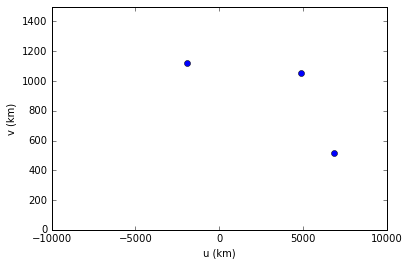

In [6]:
""" Calculate projected baseline of ARO July2015 Run """

ARO = observatory['ap']
DRAO = observatory['pe']
JB = observatory['jb']
GMRT = observatory['gmrt']

uvw_mat = np.zeros((4, 3))
t_ref = Time('2015-07-24T18:05:46.141')

i=0
for tel in [ARO, DRAO, JB, GMRT]:   
    X = tel.x
    Y = tel.y
    Z = tel.z
    Xvec = np.array([X.value, Y.value, Z.value])
    ot=Time(t_ref, scale='utc', location=ARO)
    ot.delta_ut1_utc = 0.
    obst = ot.sidereal_time('mean')

    # I'm certain there's a better astropy way to get ot_avg in degrees
    h = obst.deg*u.deg - crab.ra   
    dec = crab.dec

    # matrix to transform xyz to uvw
    mat = np.array([(np.sin(h), np.cos(h), 0), (-np.sin(dec)*np.cos(h), np.sin(dec)*np.sin(h), 
                    np.cos(dec)), (np.cos(dec)*np.cos(h), -np.cos(dec)*np.sin(h), np.sin(dec))])

    uvw = np.dot(mat, Xvec)
    uvw_mat[i] = uvw / 1000. # conversion to kilometres
    i += 1
    

uvw_AROscaled = uvw_mat - uvw_mat[0]

projb = np.sqrt( uvw_AROscaled[1:,0]**2 + uvw_AROscaled[1:,1]**2 )

plt.figure(figsize=(6,4))
plt.plot(uvw_AROscaled[1:,0], uvw_AROscaled[1:,1], 'bo')

plt.xlim(-10000, 10000)
plt.ylim(0,1500)

plt.xlabel('u (km)')
plt.ylabel('v (km)')

In [7]:
""" Projected baseline of MWA - GMRT, roughly """

MWA = observatory['gmrt']

t_ref = Time('2015-10-03T20:50:00.15')

X = MWA.x
Y = MWA.y
Z = MWA.z
Xvec = np.array([X.value, Y.value, Z.value])
ot=Time(t_ref, scale='utc', location=GMRT)
ot.delta_ut1_utc = 0.
obst = ot.sidereal_time('mean')

# I'm certain there's a better astropy way to get ot_avg in degrees
h = obst.deg*u.deg - crab.ra   
dec = crab.dec

# matrix to transform xyz to uvw
mat = np.array([(np.sin(h), np.cos(h), 0), (-np.sin(dec)*np.cos(h), np.sin(dec)*np.sin(h), 
                np.cos(dec)), (np.cos(dec)*np.cos(h), -np.cos(dec)*np.sin(h), np.sin(dec))])

uvwGMRTMWA = np.dot(mat, Xvec) / 1000

projbGM = np.sqrt( uvwGMRTMWA[0]**2 + uvwGMRTMWA[1]**2 )

In [8]:
""" Projected baseline of EVN run """

BD = observatory['bd']
EF = observatory['ef']

t_ref = Time('2015-10-19T01:23:57.220212')

X = BD.x
Y = BD.y
Z = BD.z
Xvec = np.array([X.value, Y.value, Z.value])
ot=Time(t_ref, scale='utc', location=EF)
ot.delta_ut1_utc = 0.
obst = ot.sidereal_time('mean')

# I'm certain there's a better astropy way to get ot_avg in degrees
h = obst.deg*u.deg - crab.ra   
dec = crab.dec

# matrix to transform xyz to uvw
mat = np.array([(np.sin(h), np.cos(h), 0), (-np.sin(dec)*np.cos(h), np.sin(dec)*np.sin(h), 
                np.cos(dec)), (np.cos(dec)*np.cos(h), -np.cos(dec)*np.sin(h), np.sin(dec))])

uvwEVN = np.dot(mat, Xvec) / 1000

projbEVN = np.sqrt( uvwEVN[0]**2 + uvwEVN[1]**2 )

In [9]:
""" Projected baseline of WB-AO, Alexey's run """

AR = observatory['ar']
WB = observatory['wb']

t_ref = Time('2015-01-11T00:30:44.85')

X = AR.x
Y = AR.y
Z = AR.z
Xvec = np.array([X.value, Y.value, Z.value])
ot=Time(t_ref, scale='utc', location=WB)
ot.delta_ut1_utc = 0.
obst = ot.sidereal_time('mean')

# I'm certain there's a better astropy way to get ot_avg in degrees
h = obst.deg*u.deg - crab.ra   
dec = crab.dec

# matrix to transform xyz to uvw
mat = np.array([(np.sin(h), np.cos(h), 0), (-np.sin(dec)*np.cos(h), np.sin(dec)*np.sin(h), 
                np.cos(dec)), (np.cos(dec)*np.cos(h), -np.cos(dec)*np.sin(h), np.sin(dec))])

uvwWB = np.dot(mat, Xvec) / 1000

projbWB = np.sqrt( uvwWB[0]**2 + uvwWB[1]**2 )

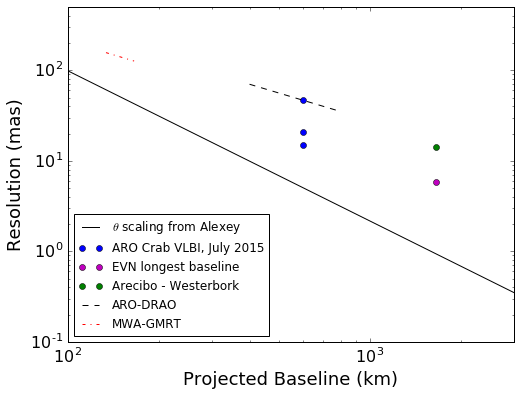

In [12]:
""" Compare VLBI resolutions to expected angular size """

freq = np.linspace(100, 3000, 100)*u.MHz
theta = theta_scaling(freq)*(206264.806247 * 1000)

res_AROrun = tel_resolution(600*u.MHz, projb)
res_ARODRAO = tel_resolution(np.linspace(400,800,100)*u.MHz, projb[0])
res_GMRTMWA = tel_resolution(np.linspace(150-16,150+16,100)*u.MHz, projbGM)
res_EVN = tel_resolution(1650*u.MHz, projbEVN)
res_WB = tel_resolution(1650*u.MHz, projbWB)

plt.figure(figsize=(8,6))

plt.plot(freq, theta, 'k', label=(r'$\theta$ scaling from Alexey'))
plt.plot([600,600,600], res_AROrun, 'bo', label='ARO Crab VLBI, July 2015')
plt.plot(1650*u.MHz, res_EVN, 'mo', label='EVN longest baseline')
plt.plot(1650*u.MHz, res_WB, 'go', label='Arecibo - Westerbork')
plt.plot(np.linspace(400,800,100)*u.MHz, res_ARODRAO, 'k--', label='ARO-DRAO')
plt.plot(np.linspace(150-16,150+16,100)*u.MHz, res_GMRTMWA, 'r-.', label='MWA-GMRT')


plt.yscale('log')
plt.xscale('log')

plt.xlim(100, 3000)
plt.ylim(0.1, 500)
plt.legend(loc=3)

plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)

plt.xlabel('Projected Baseline (km)', fontsize=18)
plt.ylabel(r'Resolution (mas)', fontsize=18)

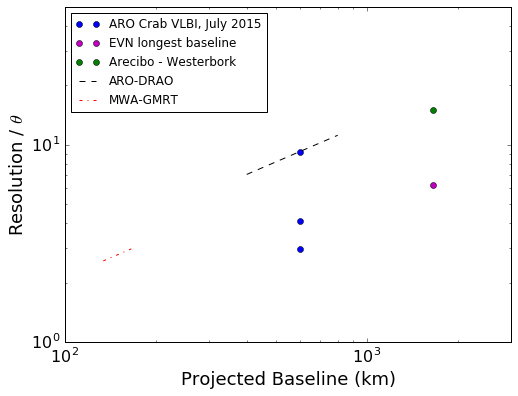

In [21]:
""" Compare VLBI resolutions to expected angular size """

plt.figure(figsize=(8,6))

#plt.plot(freq, theta, 'k', label=(r'$\theta$ scaling from Alexey'))
plt.plot([600,600,600], res_AROrun / 
         (theta_scaling(600*u.MHz)*(206264.806247 * 1000)), 'bo', label='ARO Crab VLBI, July 2015')
plt.plot(1650*u.MHz, res_EVN / 
         (theta_scaling(1650*u.MHz)*(206264.806247 * 1000)), 'mo', label='EVN longest baseline')
plt.plot(1650*u.MHz, res_WB / 
         (theta_scaling(1650*u.MHz)*(206264.806247 * 1000)), 'go', label='Arecibo - Westerbork')
plt.plot(np.linspace(400,800,100)*u.MHz, res_ARODRAO / 
         (theta_scaling(np.linspace(400,800,100)*u.MHz)*(206264.806247 * 1000)) , 'k--', label='ARO-DRAO')
plt.plot(np.linspace(150-16,150+16,100)*u.MHz, res_GMRTMWA / 
         (theta_scaling(np.linspace(150-16,150+16,100)*u.MHz)*(206264.806247 * 1000)), 'r-.', label='MWA-GMRT')


plt.yscale('log')
plt.xscale('log')

plt.xlim(100, 3000)
plt.ylim(1, 50)
plt.legend(loc=2)

plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)

plt.xlabel('Projected Baseline (km)', fontsize=18)
plt.ylabel(r'Resolution / $\theta$', fontsize=18)